# Road traffic analysis

The road traffic control is a critically important challenge in urban areas and transportation systems worldwide.
It ensures efficient, safe, and timely transportation for people and goods. Besides, this helps to reduce the carbon footprint and improve air quality as well as public health. 

Historically, traffic control has relied on manual interventions by traffic police officers, signage, and static traffic signals. These methods have limitations in handling dynamic traffic conditions and optimizing traffic flow efficiently. Modern traffic control solutions leverage advanced technologies, data analytics, and automation to address traffic congestion and improve transportation efficiency. One of the key parts in such solution pipeline is an adaptive traffic signal control system, which adjusts road signs, traffic lights based on real-time analytics.   

In this notebook we show an example of how such real-time data analysis can be made. Using any position-static video stream.

For this demo we utilize open-source YOLOv8 architecture trained on COCO dataset, capable to detect oriented bounding boxes.

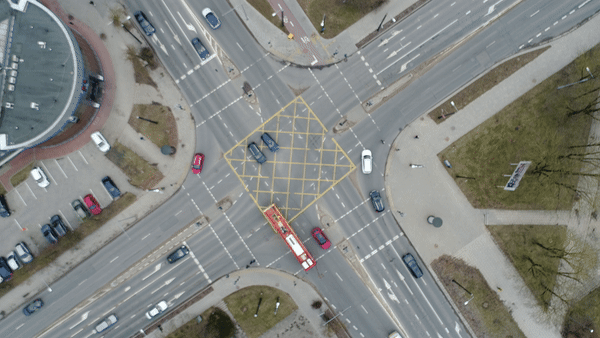

### Initialisation

In [ ]:
# Required imports
import cv2
import supervision as sv
from ultralytics import YOLO
from PIL import Image
import numpy as np
import pandas as pd
import uuid
import datetime
from arcgis.gis import GIS

In [ ]:
# Initialize your ArcGIS connection
gis = GIS(username='')
gis

### Define regions of interest


In [ ]:
ROI_POLYGON = np.array([
[772, 2],[1232, 706],[1252, 834],[1240, 1034],[1152, 1214],[8, 2046],
[8, 2150],[832, 2154],[1516, 1730],[1736, 1718],[1992, 1834],[2252, 2150],
[3040, 2158],[2516, 1386],[2452, 1166],[2496, 950],[2612, 798],[3764, 10],
[2772, 6],[2236, 374],[2012, 438],[1736, 350],[1460, 10],[776, 6]
])

streetData = [
    {
        'id': '73a7e70f-aa06-4bc0-b0d2-0e2ca4054c95', 
        'name':'Zemaites str.', 
        'color': (0,0,255),
        'poly_in': [[2248, 830],[2460, 1130],[2500, 938],[2364, 734],[2256, 822]],
        'poly_out': [[2152, 414],[2324, 662],[2192, 742],[1984, 454],[2148, 414]],
        'out': {}, 'in': {}
    }, 
    {
        'id': 'b8963170-0e35-45a0-86e2-e5aa37a31142', 
        'name':'Savanoriu str. (towards Vilkpede)',
        'color': (0,165,255),
        'poly_in': [[2156, 1586],[2076, 1470],[1716, 1706],[1872, 1754],[2136, 1594]],
        'poly_out': [[2228, 1526],[2500, 1354],[2464, 1210],[2148, 1426],[2228, 1534]],
        'out': {}, 'in': {}
    }, 
    {
        'id': '39313706-6cdb-4fae-aecb-36d4fca32ab7',
        'name':'Savanoriu str. (towards Basanav. str.)',
        'color': (255,0,0),
        'poly_in': [[1540, 454],[1624, 574],[1848, 430],[1732, 346],[1540, 466]],
        'poly_out': [[1216, 678],[1296, 802],[1552, 626],[1480, 514],[1220, 682]],
        'out': {}, 'in': {}
    }, 
    {
        'id': 'ded300c1-aa54-425d-90d6-8718e7f0a86f',
        'name':'Pietario str.',
        'color': (0,255,255),
        'poly_in': [[1388, 1298],[1228, 1062],[1160, 1186],[1292, 1366],[1384, 1306]],
        'poly_out': [[1340, 1438],[1536, 1722],[1656, 1710],[1432, 1370],[1340, 1442]],
        'out': {}, 'in': {}
    }
]

### Helper functions

In [2]:
def draw_obb(image, obb_corners, color=(0, 255, 0), thickness=10):
    '''
    Draw oriented bounding box
    '''
    for i in range(len(obb_corners)):
        pt1 = tuple(obb_corners[i].cpu().numpy().astype(int))
        pt2 = tuple(obb_corners[(i + 1) % len(obb_corners)].cpu().numpy().astype(int))
        cv2.line(image, pt1, pt2, color, thickness)
    return image

def point_inside_polygon(x, y, poly):
    '''
    Check if point is inside the polygon
    '''
    n = len(poly)
    inside = False
    p1x, p1y = poly[0]
    for i in range(n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside


def process_and_generate_df(street_df, records, directions, out_path='output_formatted'):
    '''
    Prepare recorded metadata for visualization
    '''
    # save original data
    street_df.to_csv(f'{out_path}/street_table.csv', index=False)
    gis.content.add({'title':'Streets metadata'}, f'{out_path}/street_table.csv').publish()
    records.to_csv(f'{out_path}/records_table.csv', index=False)
    gis.content.add({'title':'Traffic records'}, f'{out_path}/records_table.csv').publish()
    directions.to_csv(f'{out_path}/directions_table.csv', index=False)
    gis.content.add({'title':'Directions table'}, f'{out_path}/directions_table.csv').publish()


    # save another csv prepared for join with spatial layers in arcgis.
    in_states = records[records['state'] == 'in']
    in_states_grouped = in_states.groupby(['date', 'street_id']).size().reset_index(name='entered_vehicles')
    in_states_grouped.to_csv(f'{out_path}/in_records.csv', index=False)
    gis.content.add({'title':'In traffic records'}, f'{out_path}/in_records.csv').publish()
    

    out_states = records[records['state'] == 'out']
    out_states_grouped = out_states.groupby(['date', 'street_id']).size().reset_index(name='left_vehicles')
    out_states_grouped.to_csv(f'{out_path}/out_records.csv', index=False)
    gis.content.add({'title':'Out traffic records'}, f'{out_path}/out_records.csv').publish()

    grouped_directions = directions.groupby(['date', 'street_from', 'street_to']).size().reset_index(name='count')
    grouped_directions.to_csv(f'{out_path}/grouped_directions.csv', index=False)
    gis.content.add({'title':'Grouped directions'}, f'{out_path}/grouped_directions.csv').publish()

### Initialize variables and state

In [ ]:
video_in = "E:/LinasE/data/drono_video/traffic_stream_nadir/DJI_0395.MOV" 
video_out = "./output_formatted/stream.mov"
model = YOLO('yolov8l-obb.pt')
cap = cv2.VideoCapture(video_in)
video_info = sv.VideoInfo.from_video_path(video_in)

directions_state = {}
object_state = {}
street_df = pd.DataFrame(columns=['id', 'name'])
records = pd.DataFrame(columns=['id', 'street_id', 'date', 'state'])
directions = pd.DataFrame(columns=['id', 'date', 'street_from', 'street_to'])
ref_unix_timestamp = datetime.datetime.strptime("18/3/2024 12:45:00 PM", "%d/%m/%Y %I:%M:%S %p")

### Process video frames

Extract each video frame and run YOLO algorithm on it.

In [ ]:
with sv.VideoSink(video_out, video_info) as sink:
    while True:
        success, frame = cap.read()
        if not success:
            break
        timestep = cap.get(cv2.CAP_PROP_POS_MSEC)
        print('timestamp', int(timestep))
        date_timestamp = ref_unix_timestamp + datetime.timedelta(milliseconds=timestep)
        results = model.track(source=frame, classes=[9,10], persist=True, conf=0.3, iou=0.5)
        if results[0].obb is None:
            sink.write_frame(frame)
            continue

        boxes = results[0].obb.xyxyxyxy
        if boxes is not None:
            boxes = boxes.cpu()
        track_ids = results[0].obb.id
        if track_ids is not None:
            track_ids = track_ids.int().cpu().tolist()
        else:
            track_ids = []
            boxes = []
        for box, track_id in zip(boxes, track_ids):
            center_x = np.mean(box[:, 0].cpu().numpy())
            center_y = np.mean(box[:, 1].cpu().numpy())
            if point_inside_polygon(center_x, center_y, ROI_POLYGON):
                if track_id not in object_state:
                    object_state[track_id] = (0, 255, 0)
                for street in streetData:
                    if point_inside_polygon(center_x, center_y, street['poly_in']) and track_id not in street['in']:
                        object_state[track_id] = street['color']
                        street['in'][track_id] = True
                        records = pd.concat([records, pd.DataFrame([{'id': uuid.uuid4(), 
                                                                    'timestamp': date_timestamp,
                                                                    'date':  date_timestamp.replace(second=0, microsecond=0),
                                                                    "street_id": street['id'],
                                                                    "state":'in'}])], ignore_index=True)
                        if (track_id in directions_state):
                            directions = pd.concat([directions, pd.DataFrame([{'id': uuid.uuid4(), 
                                                                               'timestamp': date_timestamp,
                                                                               'date': date_timestamp.replace(second=0, microsecond=0), 
                                                                               "street_from": directions_state[track_id],
                                                                               "street_to": street['id']}])], ignore_index=True)
                            del directions_state[track_id]
                    if point_inside_polygon(center_x, center_y, street['poly_out']) and track_id not in street['out']:
                        street['out'][track_id] = True
                        records = pd.concat([records, pd.DataFrame([{'id': uuid.uuid4(), 
                                                                    'timestamp': date_timestamp,
                                                                    'date': date_timestamp.replace(second=0, microsecond=0), 
                                                                    "street_id": street['id'],
                                                                    "state":'out'}])], ignore_index=True)
                        directions_state[track_id] = street['id']
                frame = draw_obb(frame, box, object_state[track_id])
        # left stats
        sub_img = frame[700:1200, 0:1150]
        white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
        res = cv2.addWeighted(sub_img, 0.3, white_rect, 0.7, 1.0)
        frame[700:1200, 0:1150] = res
        y0, dy = 800, 100
        for i,street in enumerate(streetData):
            y= y0+ dy*i
            cv2.putText(frame, 
                        f"{street['name']}; In traffic: {len(street['in'])}; Out traffic: {len(street['out'])};",
                        (25, y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.25, (0,0,0), 2)

        # right stats
        sub_img2 = frame[700:1200, frame.shape[1]-1100:frame.shape[1]]
        white_rect2 = np.ones(sub_img2.shape, dtype=np.uint8) * 255
        res2 = cv2.addWeighted(sub_img2, 0.3, white_rect2, 0.7, 1.0)
        frame[700:1200, frame.shape[1]-1100:frame.shape[1]] = res2
        y, dy1, dy2 = 800, 130, 25
        for i, (_, row) in enumerate(directions.tail(3).iterrows()):
            cv2.putText(frame, 
                        f"{[d for d in streetData if d.get('id') == row['street_from']][0]['name']} ->",
                        (frame.shape[1]-1075, y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0), 2)
            y = y + dy2
            cv2.putText(frame, 
                        f"{[d for d in streetData if d.get('id') == row['street_to']][0]['name']}",
                        (frame.shape[1]-1075, y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0), 2)
            y = y + dy1
        
        sink.write_frame(frame)
cap.release()

### Video analysis example

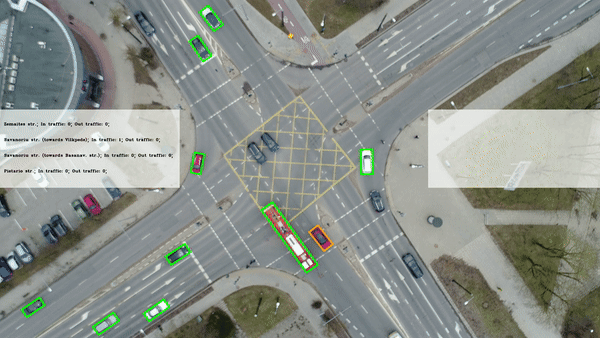

### Prepare metadata tables and publish them in ArcGIS online. 


In [ ]:
process_and_generate_df(street_df, records, directions)

### Visualize collected metadata with ArcGIS (either PRO or online) applications.

Integrate the results via ArcGIS API for Python or by using other tools.   

In [ ]:
webmap_search = gis.content.search(
  query="Traffic_data_map",
  item_type="Web Map"
)
from arcgis.mapping import WebMap
WebMap(webmap_search[0])

### Results

Find the final web map here:
https://hb.maps.arcgis.com/apps/mapviewer/index.html?webmap=36d267bf3645442c934575c4cfa4fb41

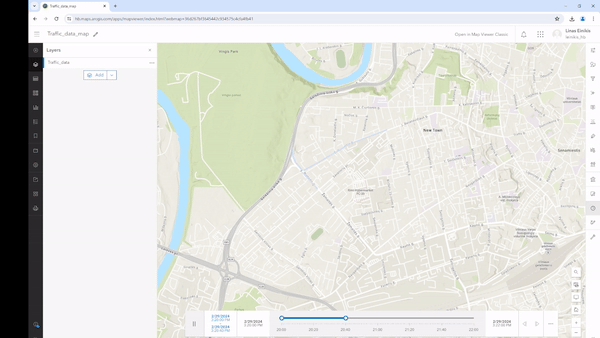